# Preliminary operations

## Import dependencies

### Pip

In [1]:
!pip install keras-tuner --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 1.7 MB/s eta 0:00:00


### Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import re
import keras_tuner

### Keras

In [4]:
from tensorflow import keras

# model
from keras.layers import Input, Embedding, Bidirectional, GRU, LSTM, SpatialDropout1D, Dropout
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, Dense, Conv1D, GlobalMaxPool1D, GlobalAveragePooling1D, SpatialDropout1D, Concatenate
from keras.models import Model, load_model
from keras.metrics import Precision, Recall, AUC
from keras.callbacks import ModelCheckpoint

# Tokenization
from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [5]:
keras.utils.set_random_seed(42)
precision_metric = Precision()
recall_metric = Recall()
auc_metric = AUC()

### Sklearn

In [6]:
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

## Def functions

### F1-Score


In [7]:
from keras.metrics import Precision, Recall, AUC, F1Score
from keras.metrics import Metric
import keras.backend as K

class F1Score(Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='true_positives', initializer='zeros')
        self.false_positives = self.add_weight(name='false_positives', initializer='zeros')
        self.false_negatives = self.add_weight(name='false_negatives', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = K.cast(y_true, dtype='float32')
        y_pred = K.cast(K.round(y_pred), dtype='float32')

        true_positives = K.sum(y_true * y_pred)
        false_positives = K.sum(K.clip(y_pred - y_true, 0, 1))
        false_negatives = K.sum(K.clip(y_true - y_pred, 0, 1))

        self.true_positives.assign_add(true_positives)
        self.false_positives.assign_add(false_positives)
        self.false_negatives.assign_add(false_negatives)

    def result(self):
        precision = self.true_positives / (self.true_positives + self.false_positives + K.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + K.epsilon())
        f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
        return K.cast(f1, dtype='float32')

f1_metric = F1Score()

### Plot

In [8]:
import matplotlib.pyplot as plt

def plot_history(history):
    # Addestramento vs. Validazione Accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    #plt.plot(history.history['f1_score'], label='Train f1_score')
    plt.plot(history.history['precision'], label='Train precision')
    plt.plot(history.history['recall'], label='Train recall')
    plt.plot(history.history['auc'], label='Train AUC')
    plt.xlabel('Epoch')
    plt.ylabel('Score Training')
    plt.legend()

    # Addestramento vs. Validazione Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    #plt.plot(history.history['val_f1_score'], label='Val f1_score')
    plt.plot(history.history['val_precision'], label='Val precision')
    plt.plot(history.history['val_recall'], label='Val recall')
    plt.plot(history.history['val_auc'], label='Val AUC')
    plt.xlabel('Epoch')
    plt.ylabel('Score Validation')
    plt.legend()

    plt.tight_layout()
    plt.show()

### cleaning text

#### pro user

In [9]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"there's", "there is", text)
    text = re.sub(r"We're", "We are", text)
    text = re.sub(r"That's", "That is", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"they're", "they are", text)
    text = re.sub(r"Can't", "Cannot", text)
    text = re.sub(r"wasn't", "was not", text)
    text = re.sub(r"don\x89Ûªt", "do not", text)
    text = re.sub(r"aren't", "are not", text)
    text = re.sub(r"isn't", "is not", text)
    text = re.sub(r"What's", "What is", text)
    text = re.sub(r"haven't", "have not", text)
    text = re.sub(r"hasn't", "has not", text)
    text = re.sub(r"There's", "There is", text)
    text = re.sub(r"He's", "He is", text)
    text = re.sub(r"It's", "It is", text)
    text = re.sub(r"You're", "You are", text)
    text = re.sub(r"I'M", "I am", text)
    text = re.sub(r"shouldn't", "should not", text)
    text = re.sub(r"wouldn't", "would not", text)
    text = re.sub(r"i'm", "I am", text)
    text = re.sub(r"I\x89Ûªm", "I am", text)
    text = re.sub(r"I'm", "I am", text)
    text = re.sub(r"Isn't", "is not", text)
    text = re.sub(r"Here's", "Here is", text)
    text = re.sub(r"you've", "you have", text)
    text = re.sub(r"you\x89Ûªve", "you have", text)
    text = re.sub(r"we're", "we are", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"we've", "we have", text)
    text = re.sub(r"it\x89Ûªs", "it is", text)
    text = re.sub(r"doesn\x89Ûªt", "does not", text)
    text = re.sub(r"It\x89Ûªs", "It is", text)
    text = re.sub(r"Here\x89Ûªs", "Here is", text)
    text = re.sub(r"who's", "who is", text)
    text = re.sub(r"I\x89Ûªve", "I have", text)
    text = re.sub(r"y'all", "you all", text)
    text = re.sub(r"can\x89Ûªt", "cannot", text)
    text = re.sub(r"would've", "would have", text)
    text = re.sub(r"it'll", "it will", text)
    text = re.sub(r"we'll", "we will", text)
    text = re.sub(r"wouldn\x89Ûªt", "would not", text)
    text = re.sub(r"We've", "We have", text)
    text = re.sub(r"he'll", "he will", text)
    text = re.sub(r"Y'all", "You all", text)
    text = re.sub(r"Weren't", "Were not", text)
    text = re.sub(r"Didn't", "Did not", text)
    text = re.sub(r"they'll", "they will", text)
    text = re.sub(r"they'd", "they would", text)
    text = re.sub(r"DON'T", "DO NOT", text)
    text = re.sub(r"That\x89Ûªs", "That is", text)
    text = re.sub(r"they've", "they have", text)
    text = re.sub(r"i'd", "I would", text)
    text = re.sub(r"should've", "should have", text)
    text = re.sub(r"You\x89Ûªre", "You are", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"Don\x89Ûªt", "Do not", text)
    text = re.sub(r"we'd", "we would", text)
    text = re.sub(r"i'll", "I will", text)
    text = re.sub(r"weren't", "were not", text)
    text = re.sub(r"They're", "They are", text)
    text = re.sub(r"Can\x89Ûªt", "Cannot", text)
    text = re.sub(r"you\x89Ûªll", "you will", text)
    text = re.sub(r"I\x89Ûªd", "I would", text)
    text = re.sub(r"let's", "let us", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"you're", "you are", text)
    text = re.sub(r"i've", "I have", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"i'll", "I will", text)
    text = re.sub(r"doesn't", "does not", text)
    text = re.sub(r"i'd", "I would", text)
    text = re.sub(r"didn't", "did not", text)
    text = re.sub(r"ain't", "am not", text)
    text = re.sub(r"you'll", "you will", text)
    text = re.sub(r"I've", "I have", text)
    text = re.sub(r"Don't", "do not", text)
    text = re.sub(r"I'll", "I will", text)
    text = re.sub(r"I'd", "I would", text)
    text = re.sub(r"Let's", "Let us", text)
    text = re.sub(r"you'd", "You would", text)
    text = re.sub(r"It's", "It is", text)
    text = re.sub(r"Ain't", "am not", text)
    text = re.sub(r"Haven't", "Have not", text)
    text = re.sub(r"Could've", "Could have", text)
    text = re.sub(r"youve", "you have", text)
    text = re.sub(r"donå«t", "do not", text)
    text = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", text)
    text = text.strip(' ')
    return text

# Dataset

## CSV

In [10]:
base_path = '/content/drive/My Drive/AML_Progetto/dataset/'

train_csv_name = 'train.csv'
test_csv_name = 'test_merged.csv'
label_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

### Train

In [11]:
train_csv_path = os.path.join(base_path, train_csv_name)
train_df = pd.read_csv(train_csv_path)

In [12]:
len(train_df)

159571

In [13]:
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


### Test

In [14]:
test_csv_path = os.path.join(base_path, test_csv_name)
test_df = pd.read_csv(test_csv_path)

In [15]:
len(test_df)

63978

In [16]:
test_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0001ea8717f6de06,Thank you for understanding. I think very high...,0,0,0,0,0,0
1,000247e83dcc1211,:Dear god this site is horrible.,0,0,0,0,0,0
2,0002f87b16116a7f,"""::: Somebody will invariably try to add Relig...",0,0,0,0,0,0
3,0003e1cccfd5a40a,""" \n\n It says it right there that it IS a typ...",0,0,0,0,0,0
4,00059ace3e3e9a53,""" \n\n == Before adding a new product to the l...",0,0,0,0,0,0


## Check


In [17]:
# check null value
train_df.isnull().any(), test_df.isnull().any()

(id               False
 comment_text     False
 toxic            False
 severe_toxic     False
 obscene          False
 threat           False
 insult           False
 identity_hate    False
 dtype: bool,
 id               False
 comment_text     False
 toxic            False
 severe_toxic     False
 obscene          False
 threat           False
 insult           False
 identity_hate    False
 dtype: bool)

## Exploration

In [18]:
x = train_df.iloc[:,2:].sum()
print(x)

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64


In [19]:
rowsums=train_df.iloc[:,2:].sum(axis=1)
train_df['non_toxic']=(rowsums==0)

train_df['non_toxic'].sum()
print("Total comments = ", len(train_df))
print("Total clean comments = ",train_df['non_toxic'].sum())

Total comments =  159571
Total clean comments =  143346


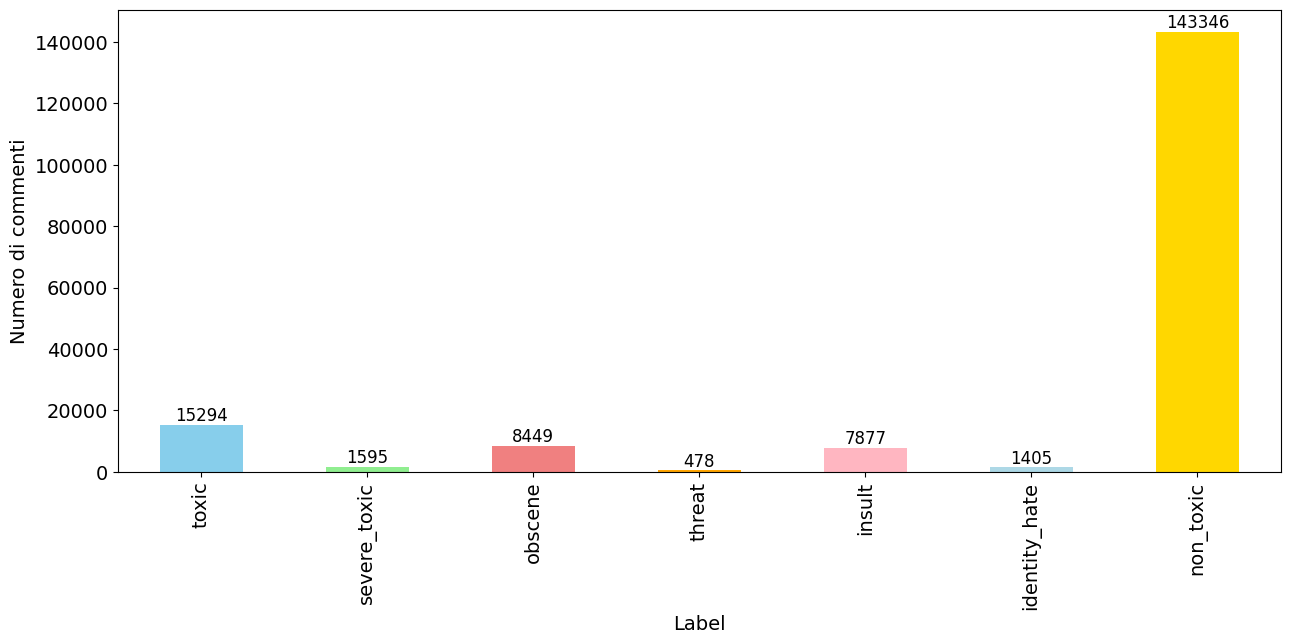

In [20]:
# Calcola il numero di esempi per label
label_counts = train_df.iloc[:, 2:].sum()

colors = ['skyblue', 'lightgreen', 'lightcoral', 'orange', 'lightpink', 'lightblue', 'gold']

# Crea un grafico a barre con colori diversi e sfondo bianco
plt.figure(figsize=(15, 6))
ax = label_counts.plot(kind='bar', color=colors, fontsize=14)
ax.set_facecolor('white')  # Sfondo bianco
plt.xlabel('Label', fontsize=14)
plt.ylabel('Numero di commenti', fontsize=14)

# Aggiungi etichette con il numero di esempi sopra le barre
for i, v in enumerate(label_counts):
    ax.text(i, v + 5, str(v), ha='center', va='bottom', fontsize=12, color='black')


plt.show()

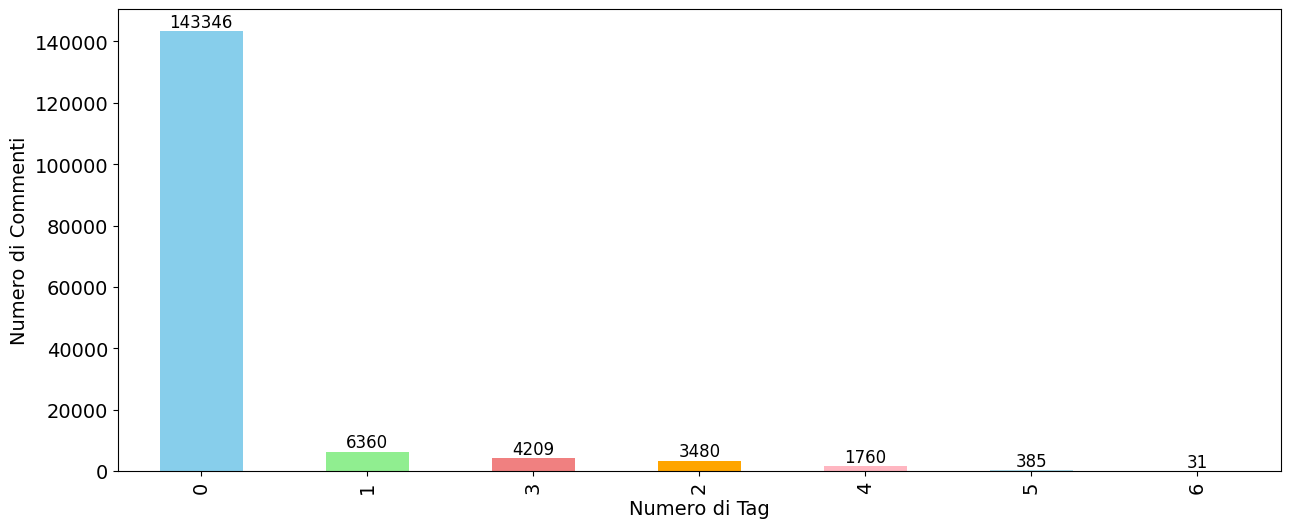

In [21]:
# Calcola il numero di tag per ogni commento
x = rowsums.value_counts()

colors = ['skyblue', 'lightgreen', 'lightcoral', 'orange', 'lightpink', 'lightblue', 'gold']

# Crea un grafico a barre per visualizzare il numero di commenti con un numero specifico di tag
plt.figure(figsize=(15, 6))
ax = x.plot(kind='bar', color=colors, fontsize=14)
ax.set_facecolor('white')  # Sfondo bianco
plt.xlabel('Numero di Tag', fontsize=14)  # Imposta la dimensione del font
plt.ylabel('Numero di Commenti', fontsize=14)  # Imposta la dimensione del font

rects = ax.patches
labels = x.values

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=12)  # Imposta la dimensione del font

plt.show()


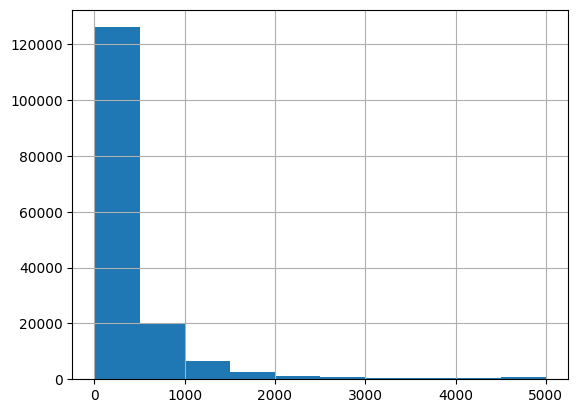

In [22]:
lens = train_df.comment_text.str.len()
lens.mean(), lens.std(), lens.max()
lens.hist();

## Class weights

In [23]:
subset_labels = train_df[label_columns]

class_frequencies = subset_labels.sum(axis=0)
class_weights = compute_class_weight('balanced', classes = [0, 1], y = np.ravel(subset_labels))
class_weights_based_on_frequencies = class_frequencies.sum() / (class_frequencies * len(class_frequencies))

class_weights_based_on_frequencies

toxic             0.382481
severe_toxic      3.667503
obscene           0.692350
threat           12.237796
insult            0.742626
identity_hate     4.163464
dtype: float64

## Lower case

In [24]:
train_df["comment_text"] = train_df["comment_text"].str.lower()
test_df["comment_text"] = test_df["comment_text"].str.lower()

## Clean dataset


In [25]:
train_df['comment_text'] = train_df['comment_text'].map(lambda com : clean_text(com))
test_df['comment_text'] = test_df['comment_text'].map(lambda com : clean_text(com))

## Labels

In [26]:
y_train = train_df[label_columns].values
y_test = test_df[label_columns].values

# Tokenization

## Check sequence length

count    159571.000000
mean        376.991953
std         567.071500
min           4.000000
25%          90.000000
50%         196.000000
75%         418.000000
max        5121.000000
Name: comment_text, dtype: float64


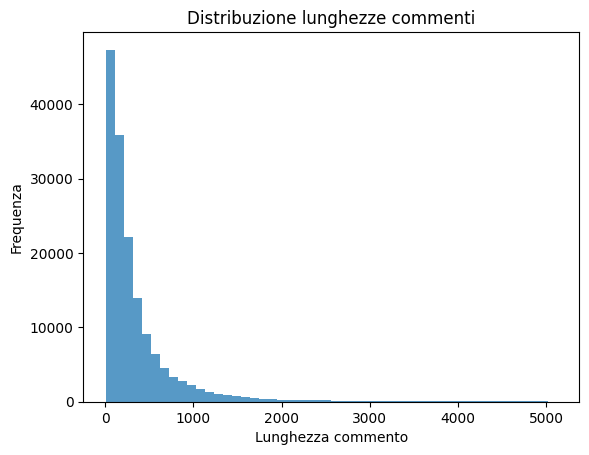

In [27]:
comment_lengths = train_df['comment_text'].apply(len)
print(comment_lengths.describe())

plt.hist(comment_lengths, bins=50, alpha=0.75)
plt.xlabel('Lunghezza commento')
plt.ylabel('Frequenza')
plt.title('Distribuzione lunghezze commenti')
plt.show()

## Check number of words

In [28]:
tokenizer_temp = Tokenizer(lower=True)
tokenizer_temp.fit_on_texts(train_df['comment_text'])
word_index = tokenizer_temp.word_index

# Numero totale di parole nel vocabolario
total_words = len(word_index)

# Visualizza il numero totale di parole nel vocabolario
print(f"\nNumero totale di parole nel vocabolario: {total_words}")


Numero totale di parole nel vocabolario: 187000


## Tokenization process

In [29]:
max_seq_len = 200
max_words = 20000

list_sentences_train = train_df["comment_text"]
list_sentences_test = test_df["comment_text"]

In [30]:
tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(list(list_sentences_train))

### Create Sequence

In [31]:
train_sequences = tokenizer.texts_to_sequences(list_sentences_train)
test_sequences = tokenizer.texts_to_sequences(list_sentences_test)

### Padding

In [32]:
x_train = pad_sequences(train_sequences, maxlen = max_seq_len)
x_test  = pad_sequences(test_sequences, maxlen = max_seq_len)

# Tuning Hyperparameters

## Define tuning model

In [34]:
def build_model(hp):
    input_layer = Input(shape=(max_seq_len,))
    embedding_layer = Embedding(
        input_dim=max_words,
        output_dim=hp.Int('embed_size', min_value=100, max_value=400, step=50))(input_layer)
    spatial_dropout_layer = SpatialDropout1D(
        rate=hp.Float("spatial_dropout_rate", min_value=0.1, max_value=0.6, step=0.1),
        name='spatial_dropout')(embedding_layer)

    recurrent_layer_type = hp.Choice("recurrent_layer", ["LSTM", "GRU"])
    recurrent_units = hp.Int("units_bi", min_value=60, max_value=300, step=30)
    recurrent_dropout = hp.Float("dropout_bi", min_value=0.1, max_value=0.6, step=0.1)

    if recurrent_layer_type == "LSTM":
        recurrent_layer = Bidirectional(
            LSTM(units=recurrent_units, dropout=recurrent_dropout, return_sequences=True, name='lstm_layer'))(
            spatial_dropout_layer)
    elif recurrent_layer_type == "GRU":
        recurrent_layer = Bidirectional(
            GRU(units=recurrent_units, dropout=recurrent_dropout, return_sequences=True, name='gru_layer'))(
            spatial_dropout_layer)

    global_maxpool_layer = GlobalMaxPool1D()(recurrent_layer)

    dense_units = hp.Int("units_dense", min_value=50, max_value=300, step=50)
    dense_activation = hp.Choice("activation", ["relu", "selu", "elu"])
    dense_layer = Dense(units=dense_units, activation=dense_activation, name='dense_layer')(global_maxpool_layer)

    dropout_rate_dense = hp.Float("dropout_dense", min_value=0.1, max_value=0.6, step=0.1)
    dropout_layer_dense = Dropout(rate=dropout_rate_dense, name='dropout_dense')(dense_layer)

    output_layer = Dense(6, activation="sigmoid", name='output_layer')(dropout_layer_dense)

    learning_rate = hp.Float("lr", min_value=0.00001, max_value=0.01, sampling="log")

    optimizer_choice = hp.Choice('optimizer', ["adam", "rmsprop", "sgd"])
    if optimizer_choice == 'adam':
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_choice == 'rmsprop':
        optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer_choice == 'sgd':
        optimizer = keras.optimizers.SGD(learning_rate=learning_rate)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy', f1_metric, precision_metric, recall_metric, auc_metric])

    return model

build_model(keras_tuner.HyperParameters())

## Options

In [35]:
tuner = keras_tuner.RandomSearch(
    hypermodel = build_model,
    objective = "val_loss",
    max_trials = 6,
    executions_per_trial = 2,
    overwrite = True,
    directory="/content/drive/My Drive/AML_Progetto/RNN/",
    project_name="tuner_rnn",
)

tuner.search_space_summary()

Search space summary
Default search space size: 10
embed_size (Int)
{'default': None, 'conditions': [], 'min_value': 100, 'max_value': 400, 'step': 50, 'sampling': 'linear'}
spatial_dropout_rate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.6, 'step': 0.1, 'sampling': 'linear'}
recurrent_layer (Choice)
{'default': 'LSTM', 'conditions': [], 'values': ['LSTM', 'GRU'], 'ordered': False}
units_bi (Int)
{'default': None, 'conditions': [], 'min_value': 60, 'max_value': 300, 'step': 30, 'sampling': 'linear'}
dropout_bi (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.6, 'step': 0.1, 'sampling': 'linear'}
units_dense (Int)
{'default': None, 'conditions': [], 'min_value': 50, 'max_value': 300, 'step': 50, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'selu', 'elu'], 'ordered': False}
dropout_dense (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.6, 'step': 0.1

## Search

In [36]:
X_train, x_val, Y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [ ]:
tuner.search(X_train, Y_train, epochs=3, validation_data=(x_val, y_val))

Trial 5 Complete [00h 14m 49s]
val_loss: 0.0448587778955698

Best val_loss So Far: 0.04381897300481796
Total elapsed time: 01h 18m 40s

Search: Running Trial #6

Value             |Best Value So Far |Hyperparameter
325               |400               |embed_size
0.4               |0.5               |spatial_dropout_rate
LSTM              |LSTM              |recurrent_layer
220               |190               |units_bi
0.4               |0.4               |dropout_bi
100               |200               |units_dense
selu              |selu              |activation
0.3               |0.4               |dropout_dense
0.00035121        |0.00072139        |lr

Epoch 1/3
3990/3990 [==============================] - 198s 48ms/step - loss: 0.0699 - accuracy: 0.7981 - f1_score: 0.6656 - precision: 0.7743 - recall: 0.5837 - auc: 0.9634 - val_loss: 0.0495 - val_accuracy: 0.9484 - val_f1_score: 0.7211 - val_precision: 0.8620 - val_recall: 0.6197 - val_auc: 0.9815
Epoch 2/3
3990/3990 [===========

## Results

In [ ]:
tuner.results_summary()

In [ ]:
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
model = models[0]
model.summary()

model.save('/content/drive/My Drive/AML_Progetto/RNN/Best_Model/best_tuned_RNN.h5')

# Train RNN

In [39]:
check_path = '/content/drive/My Drive/AML_Progetto/RNN/Best_Model/best_RNN_unimb.h5'

embed_size = 250
batch_size = 32
epochs = 3

## build model

In [40]:
inp = Input(shape=(max_seq_len, ), name = 'input_layer')
embedding_layer = Embedding(max_words, embed_size, name ='embedding_layer')(inp)
x = SpatialDropout1D(0.5, name='spatial_dropout')(embedding_layer)
x = Bidirectional(LSTM(120, return_sequences=True, dropout = 0.3, name='lstm_layer'))(x)
x = GlobalMaxPool1D(name = 'global_max_pool')(x)
x = Dense(125, activation="selu", name = 'dense_layer')(x)
x = Dropout(0.3, name = 'dropout_layer')(x)
output = Dense(6, activation="sigmoid", name = 'output_layer')(x)

model = Model(inputs=inp, outputs=output)

In [41]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 200)]             0         
                                                                 
 embedding_layer (Embedding  (None, 200, 250)          5000000   
 )                                                               
                                                                 
 spatial_dropout (SpatialDr  (None, 200, 250)          0         
 opout1D)                                                        
                                                                 
 bidirectional_2 (Bidirecti  (None, 200, 240)          356160    
 onal)                                                           
                                                                 
 global_max_pool (GlobalMax  (None, 240)               0         
 Pooling1D)                                                

In [42]:
model.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.0007213894202014545),
              loss='binary_crossentropy',
              metrics=['accuracy', precision_metric, recall_metric, auc_metric])

## Callbacks

In [43]:
checkpoint = ModelCheckpoint(check_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

## fit

In [45]:
history = model.fit(
    x_train,
    y_train,
    batch_size = batch_size,
    epochs=epochs,
    callbacks=callbacks_list,
    class_weight=dict(enumerate(class_weights_based_on_frequencies)),
    validation_split=0.2)

Epoch 1/3
3989/3990 [============================>.] - ETA: 0s - loss: 0.0176 - accuracy: 0.8766 - precision: 0.8350 - recall: 0.7337 - auc: 0.9889
Epoch 1: val_loss improved from 0.04521 to 0.04479, saving model to /content/drive/My Drive/AML_Progetto/RNN/Best_Model/best_RNN_unimb.h5
3990/3990 [==============================] - 104s 26ms/step - loss: 0.0176 - accuracy: 0.8766 - precision: 0.8350 - recall: 0.7337 - auc: 0.9889 - val_loss: 0.0448 - val_accuracy: 0.9747 - val_precision: 0.7913 - val_recall: 0.7316 - val_auc: 0.9814
Epoch 2/3
3990/3990 [==============================] - ETA: 0s - loss: 0.0161 - accuracy: 0.8384 - precision: 0.8433 - recall: 0.7577 - auc: 0.9902
Epoch 2: val_loss did not improve from 0.04479
3990/3990 [==============================] - 97s 24ms/step - loss: 0.0161 - accuracy: 0.8384 - precision: 0.8433 - recall: 0.7577 - auc: 0.9902 - val_loss: 0.0480 - val_accuracy: 0.7607 - val_precision: 0.7759 - val_recall: 0.7331 - val_auc: 0.9768
Epoch 3/3
3990/3990 

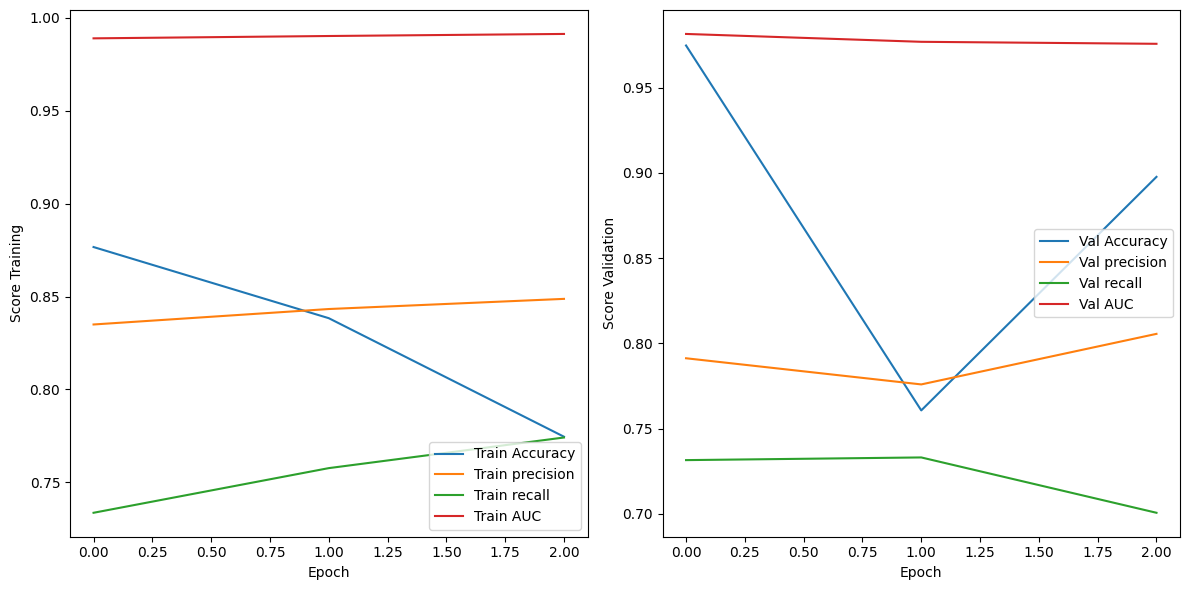

In [46]:
plot_history(history)

# Test RNN

## Load model

In [49]:
model = load_model('/content/drive/My Drive/AML_Progetto/RNN/Best_Model/best_RNN_tuned.h5')

## Predict

In [50]:
y_pred = model.predict(x_test)

2000/2000 [==============================] - 14s 7ms/step


## Classification Report

In [51]:
binary_predictions = (y_pred > 0.5).astype(int)
print(classification_report(y_test, binary_predictions, target_names=label_columns))

               precision    recall  f1-score   support

        toxic       0.56      0.85      0.68      6090
 severe_toxic       0.33      0.53      0.41       367
      obscene       0.62      0.79      0.69      3691
       threat       0.52      0.38      0.44       211
       insult       0.61      0.71      0.65      3427
identity_hate       0.60      0.53      0.56       712

    micro avg       0.58      0.77      0.66     14498
    macro avg       0.54      0.63      0.57     14498
 weighted avg       0.58      0.77      0.66     14498
  samples avg       0.07      0.07      0.07     14498



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Confusion Matrix

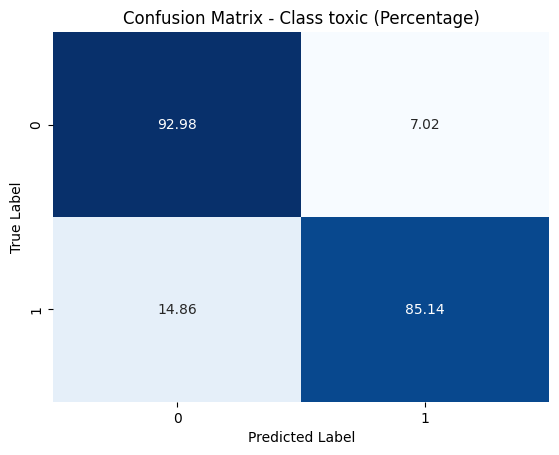

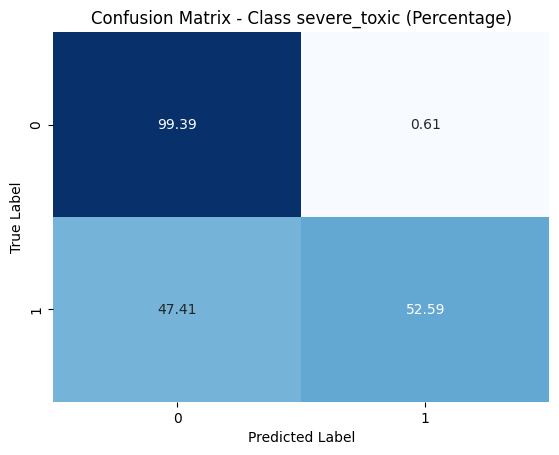

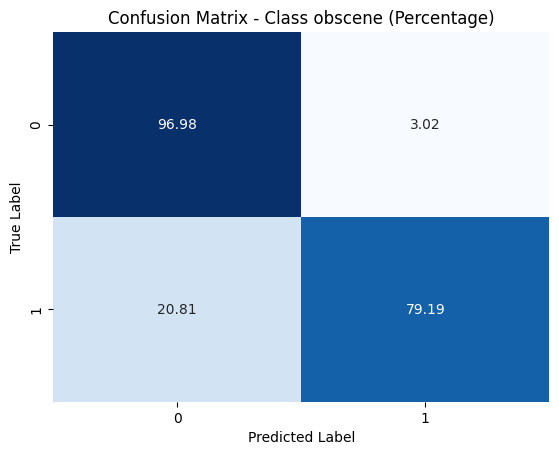

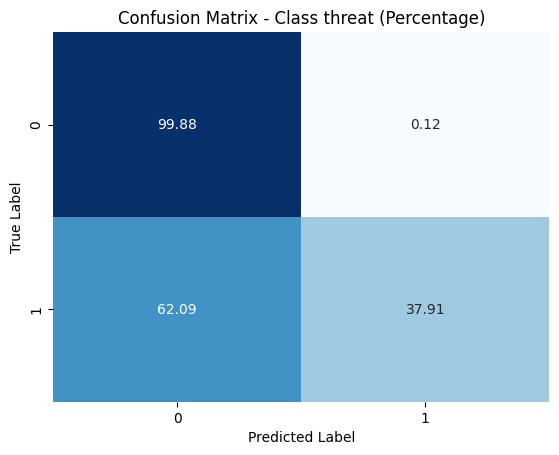

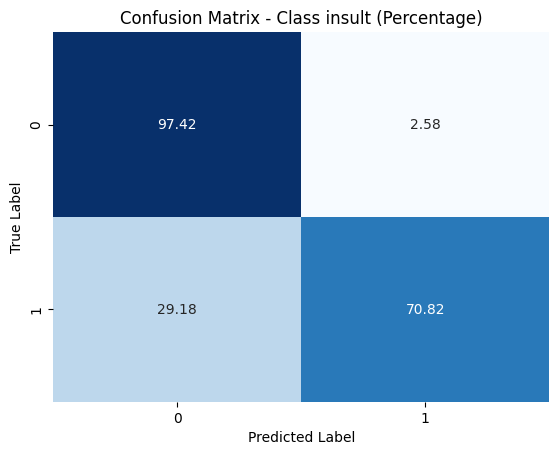

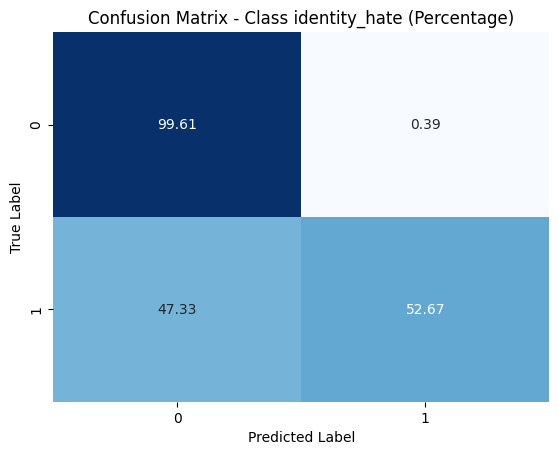

In [52]:
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns
conf_matrix = multilabel_confusion_matrix(y_test, binary_predictions)

for i, matrix in enumerate(conf_matrix):
    row_sums = matrix.sum(axis=1, keepdims=True)

    # Normalize the confusion matrix to get percentages
    matrix = matrix / row_sums.astype(float) * 100 if row_sums.any() else matrix

    sns.heatmap(matrix, annot=True, fmt=".2f", cmap="Blues", cbar=False)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - Class {label_columns[i]} (Percentage)")
    plt.show()

# Scartate

## Undersampling clean

da mettere nella sezione Dataset, dopo la sezione **Exploration**, nel caso si voglia testare il modell diminuendo la classe clean

In [ ]:
train_df[label_columns].sum().sort_values()

# Create subsets based on toxic and clean comments
train_toxic = train_df[train_df[label_columns].sum(axis=1) > 0]

# Randomly sample 16225 clean comments
train_clean = train_df[train_df[label_columns].sum(axis=1) == 0]
train_clean_sampled = train_clean.sample(n = 16225, random_state = 42)

# Combine the toxic and sampled clean comments
train_df = pd.concat([train_toxic, train_clean_sampled], axis=0)

# Shuffle the data to avoid any order bias during training
train_df = train_df.sample(frac = 1, random_state = 42)

print("train toxic: ", train_toxic.shape)
print("train clean: ", train_clean_sampled.shape)
print("new train: ", train_df.shape)

## Data augmentation

da sperimentare nella sezione dataset, prima di **Labels**

In [ ]:
%pip install nlpaug
import nlpaug
import nlpaug.augmenter.word as naw
from tqdm import tqdm
# Crea un oggetto di augumentation per sinonimi
aug = naw.SynonymAug(aug_src='wordnet', aug_max=8)

In [ ]:
# DataFrame contenente le righe di train_df per cui 'threat' è uguale a 1
subset_text_minority = train_df[(train_df['threat'] == 1) | (train_df['identity_hate'] == 1) & (train_df['toxic'] == 0)]

# Lista per contenere i dati aumentati
augmented_text_minority = []

# Applica la data augmentation ai dati di testo delle classi minoritarie
for i in tqdm(range(subset_text_minority.shape[0]), desc='tqdm() Progress Bar'):
    row = subset_text_minority.iloc[i]
    text = row['comment_text']
    label_values = row[label_columns].values  # Conserva i valori delle label
    # Aumenta il testo per 10 volte
    augmented_data = [{'id': f"{row['id']}_aug_{j}", 'comment_text': aug.augment(text), **dict(zip(label_columns, label_values))} for j in range(10)]
    augmented_text_minority.extend(augmented_data)

augmented_df_minority = pd.DataFrame(augmented_text_minority)
train_df = pd.concat([train_df, augmented_df_minority], ignore_index=True)

In [ ]:
# DataFrame contenente le righe di train_df per cui 'threat' è uguale a 1
subset_text_minority = train_df[(train_df['severe_toxic'] == 1)]

# Lista per contenere i dati aumentati
augmented_text_minority = []

# Applica la data augmentation ai dati di testo delle classi minoritarie
for i in tqdm(range(subset_text_minority.shape[0]), desc='tqdm() Progress Bar'):
    row = subset_text_minority.iloc[i]
    text = row['comment_text']
    label_values = row[label_columns].values  # Conserva i valori delle label
    # Aumenta il testo per 10 volte
    augmented_data = [{'id': f"{row['id']}_aug_{j}", 'comment_text': aug.augment(text), **dict(zip(label_columns, label_values))} for j in range(2)]
    augmented_text_minority.extend(augmented_data)

augmented_df_minority = pd.DataFrame(augmented_text_minority)
train_df = pd.concat([train_df, augmented_df_minority], ignore_index=True)

In [ ]:
subset_labels = train_df[label_columns]
class_frequencies = subset_labels.sum(axis=0)
class_weights_based_on_frequencies = class_frequencies.sum() / (class_frequencies * len(class_frequencies))

class_weights_based_on_frequencies

## Lemmatization

In [ ]:
import os
import pandas as pd
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

In [ ]:
def lemmatize_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)

    # Initialize lemmatizer
    lemmatizer = WordNetLemmatizer()

    # Lemmatize each token
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Join the lemmatized tokens back into a text
    lemmatized_text = ' '.join(lemmatized_tokens)

    return lemmatized_text

In [ ]:
train_df['comment_text'] = train_df['comment_text'].map(lambda com: lemmatize_text(com))

## Embedding

In [ ]:
def load_glove_embeddings(embedding_file):
    embeddings_index = {}
    with open(embedding_file, 'r', encoding='utf-8') as f:
        lines = f.readlines()
        for line in tqdm(lines, desc='Loading GloVe Embeddings', unit='lines'):
            values = line.split()
            word = values[0]
            try:
                coefs = np.asarray(values[1:], dtype='float32')
                embeddings_index[word] = coefs
            except ValueError:
                # Se non riesce a convertire in float, salta questa riga
                continue
    return embeddings_index

glove_file = '/content/drive/My Drive/AML_Progetto/RNN/GloVe/glove.840B.300d.txt'
glove_embeddings = load_glove_embeddings(glove_file)

In [ ]:
embedding_dim = 300  # in base al file caricato
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

for word, i in word_index.items():
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_layer = Embedding(
    input_dim=len(word_index) + 1,
    output_dim = embed_size,
    weights=[embedding_matrix],
    input_length=max_seq_len,
    trainable = False,
    name ='embedding_layer'
)(inp)